https://jpx.gitbook.io/j-quants-ja/outline/getstarted

In [1]:
import requests
import json
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib # 横軸ラベルの設定など
import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats
import statsmodels.api as sm
import networkx as nx
from filterpy.kalman import KalmanFilter # 固変分解に利用
import yfinance as yf # 為替データを取得
import pandas_datareader.data as pdr
plt.style.use("ggplot")
plt.rcParams['font.family'] = "MS Gothic"
plt.rcParams["font.size"] = 20

データを読み込み

In [15]:
df_all = pd.read_excel("data_input.xlsx")
df_all["const"] = 1.0 # 定数項ファクターとして追加した方が統一的に扱えてラク
df_all

,ID,ID_COMPANY,NAME,DATE,ROE,DIV_RATIO,PBR,const
0,1,1,A,200412,0.051099,0.272703,1.362385,1.0
1,2,2,B,200412,0.103326,0.351057,2.910860,1.0
2,3,3,C,200412,0.079051,0.188103,2.099210,1.0
3,4,4,D,200412,0.120987,0.364455,3.389623,1.0
4,5,5,E,200412,0.054196,0.326540,1.704584,1.0
...,...,...,...,...,...,...,...,...
395,396,16,P,202312,0.069762,0.231095,1.718923,1.0
396,397,17,Q,202312,0.065209,0.297873,1.835281,1.0
397,398,18,R,202312,0.116127,0.292781,3.025120,1.0
398,399,19,S,202312,0.114889,0.424471,3.028292,1.0


各時点での回帰分析結果をテーブルの形で格納する

<AxesSubplot:xlabel='DATE', ylabel='coef'>

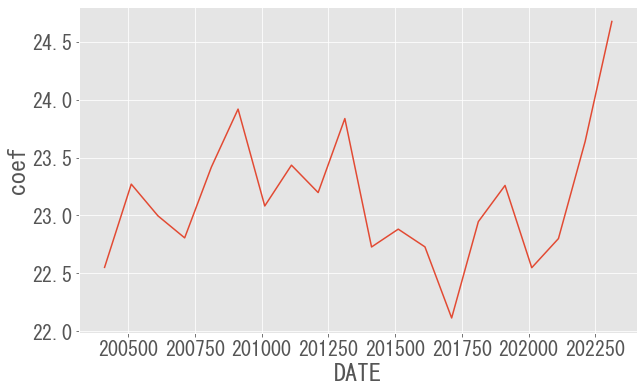

In [64]:
date_list = df_all["DATE"].unique()
factor_list = ["ROE", "DIV_RATIO", "const"]
df_result = None

for date in date_list:
    df_date = df_all[df_all["DATE"] == date].reset_index(drop = True)
    model_date = sm.OLS(df_date["PBR"], df_date[factor_list])
    result = model_date.fit()
    df_result_date = pd.DataFrame({"DATE": date, "factor": "", "coef":result.params, "t_value": result.tvalues, "R2": result.rsquared, "N": result.nobs})
    df_result = pd.concat([df_result, df_result_date])
# df_result.reset_index(inplace = True)
df_result["factor"] = df_result.index.values
df_result.reset_index(drop = True, inplace = True)
df_result.head()

plt.figure(figsize = (10, 6))
sns.lineplot(data = df_result[df_result["factor"] == "ROE"], x = "DATE", y = "coef")

横持ちにして係数のみを取り出した方が使いやすい

In [26]:
factor_coef_list = ["COEF_" + s for s in factor_list]
df_coef = df_result.pivot_table(columns = "factor", values = "coef", index = "DATE").reset_index()
df_coef.rename(columns = dict(zip(factor_list, factor_coef_list)), inplace = True)
df_coef

factor,DATE,COEF_DIV_RATIO,COEF_ROE,COEF_const
0,200412,1.335592,22.551660,-0.085779
1,200512,1.085897,23.271013,-0.080021
2,200612,0.536825,22.996767,0.126284
3,200712,0.474532,22.806608,0.133371
4,200812,0.817266,23.418125,-0.016820
5,200912,0.641725,23.919285,-0.001346
6,201012,1.024656,23.082328,-0.052301
7,201112,0.852433,23.434828,-0.021035
8,201212,0.279527,23.198143,0.189156
9,201312,1.195052,23.837700,-0.165304


各時点の各企業に係数を追加し，PBRの差分を以下のように分解する：
$$
\Delta {\rm PBR}_t = \sum_i (\Delta c_{i, t} \tilde{f}_{i, t} + \tilde{c}_{i, t} \Delta f_{i, t}) + \Delta e_t
$$
ただし数値誤差を低減するため，
$$
\tilde{f}_{i, t} = (f_{i, t-1} + f_{i, t}) / 2
$$
のように工夫している．

In [48]:
df_agg = df_all.merge(df_coef, how = "left", on = "DATE")
# PBR変動の要因分解には残差を計算する必要あり
factor_contribute_list = ["CONTRIBUTE_" + s for s in factor_list] # ファクター×係数の列
df_agg[factor_contribute_list] = df_agg[factor_coef_list].values * df_agg[factor_list].values
df_agg["PBR_EST"] = df_agg[factor_contribute_list].sum(axis = 1)
df_agg["PBR_RESIDUAL"] = df_agg["PBR"] - df_agg["PBR_EST"]

# PBR変動の要因分解に必要なファクター
factor_delta_list = factor_list + factor_coef_list + ["PBR", "PBR_RESIDUAL"]
for factor in factor_delta_list:
    df_agg["d_" + factor] = df_agg.groupby("ID_COMPANY")[factor].shift(1) - df_agg[factor] # 各ファクターの差分を計算
    df_agg["MID_" + factor] = (df_agg.groupby("ID_COMPANY")[factor].shift(1) + df_agg[factor]) * 0.5 # 直近時点との平均値（全微分の数値誤差を減らす）

# d_PBR_BYは各ファクターおよび係数（と残差）の変化による寄与分を表す
for factor in factor_list:
    df_agg["d_PBR_BY_" + factor] = df_agg["MID_COEF_" + factor] * df_agg["d_" + factor] # factorの変動による寄与
    df_agg["d_PBR_BY_COEF_" + factor] = df_agg["d_COEF_" + factor] * df_agg["MID_" + factor] # 係数の変動による寄与
df_agg["d_PBR_BY_RESIDUAL"] = df_agg["d_PBR_RESIDUAL"].copy()
df_agg

,ID,ID_COMPANY,NAME,DATE,ROE,DIV_RATIO,PBR,const,COEF_DIV_RATIO,COEF_ROE,...,MID_PBR,d_PBR_RESIDUAL,MID_PBR_RESIDUAL,d_PBR_BY_ROE,d_PBR_BY_COEF_ROE,d_PBR_BY_DIV_RATIO,d_PBR_BY_COEF_DIV_RATIO,d_PBR_BY_const,d_PBR_BY_COEF_const,d_PBR_BY_RESIDUAL
0,1,1,A,200412,0.051099,0.272703,1.362385,1.0,1.335592,22.551660,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2,B,200412,0.103326,0.351057,2.910860,1.0,1.335592,22.551660,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,3,C,200412,0.079051,0.188103,2.099210,1.0,1.335592,22.551660,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,4,D,200412,0.120987,0.364455,3.389623,1.0,1.335592,22.551660,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,5,E,200412,0.054196,0.326540,1.704584,1.0,1.335592,22.551660,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,396,16,P,202312,0.069762,0.231095,1.718923,1.0,0.060053,24.676599,...,1.943085,-0.017368,-0.122325,0.507265,-0.083246,-0.004834,0.135318,0.0,-0.08881,-0.017368
396,397,17,Q,202312,0.065209,0.297873,1.835281,1.0,0.060053,24.676599,...,1.673565,-0.008595,0.106756,-0.354661,-0.060021,0.004929,0.183726,0.0,-0.08881,-0.008595
397,398,18,R,202312,0.116127,0.292781,3.025120,1.0,0.060053,24.676599,...,2.856899,0.086227,0.087814,-0.428900,-0.111240,0.016215,0.190067,0.0,-0.08881,0.086227
398,399,19,S,202312,0.114889,0.424471,3.028292,1.0,0.060053,24.676599,...,2.898232,-0.025513,0.057757,-0.304843,-0.112619,0.008567,0.263098,0.0,-0.08881,-0.025513


`d_PBR_BY`と`d_PBR`を表示

In [50]:
factor_d_list = ["d_PBR_BY_" + s for s in factor_list + factor_coef_list + ["RESIDUAL"]]
df_agg[factor_d_list + ["d_PBR"]]

,d_PBR_BY_ROE,d_PBR_BY_DIV_RATIO,d_PBR_BY_const,d_PBR_BY_COEF_ROE,d_PBR_BY_COEF_DIV_RATIO,d_PBR_BY_COEF_const,d_PBR_BY_RESIDUAL,d_PBR
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
395,0.507265,-0.004834,0.0,-0.083246,0.135318,-0.08881,-0.017368,0.448325
396,-0.354661,0.004929,0.0,-0.060021,0.183726,-0.08881,-0.008595,-0.323432
397,-0.428900,0.016215,0.0,-0.111240,0.190067,-0.08881,0.086227,-0.336441
398,-0.304843,0.008567,0.0,-0.112619,0.263098,-0.08881,-0.025513,-0.260120


明らかにROE変動の要因が大きそうなので確認してみる．

<AxesSubplot:xlabel='DATE', ylabel='d_PBR'>

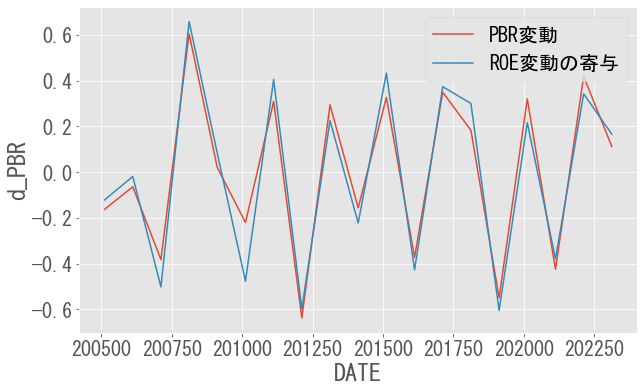

In [69]:
plt.figure(figsize = (10, 6))
sns.lineplot(data = df_agg[df_agg["ID_COMPANY"] == 1], x = "DATE", y = "d_PBR", label = "PBR変動")
sns.lineplot(data = df_agg[df_agg["ID_COMPANY"] == 1], x = "DATE", y = "d_PBR_BY_ROE", label = "ROE変動の寄与")